# Hyperparameter Tuning Tutorial

Machine learning models often have many hyperparameters that need to be tuned to achieve maximal performance (e.g: learning rate, dropout rate, number of layers, layer size, etc) . This motivates the need for hyperparameter tuners that intelligently search the space of hyperparameters for a high performing model. 

To address this, MeTaL supports multiple hyperparameter tuners with an easy to use interface which allows users to streamline the hyperparameter optimization process. This tutorial covers utilizing MeTaL's hyperparameter tuners to tune an EndModel for maximal performance. Currently, two hyperparameter algorithms are supported:

- <b>Random Search</b>
- <b>Hyperband</b>

The tutorial is broken down into the following sections 

1. <b>Set up the Problem and Load the Data</b>
2. <b>Define the Search Space</b>
3. <b>Run Random Search</b>
4. <b>Run Hyperband Search</b>
5. <b>Compare Random Search against Hyperband Search</b>

Let's begin!

## Setup
Before beginning, we first need to make sure that the metal/ directory is on our Python path. If the following cell runs without an error, you're all set. If not, make sure that you've installed snorkel-metal with pip or conda (or that you've added the repo to your path if you're running from source; for example, running source add_to_path.sh from the repository root).

In [1]:
import matplotlib
%load_ext autoreload
%autoreload 2
%matplotlib inline
import metal

## Set up the Problem and Load the Data

First let's set up our problem and load our data. For the purposes of this tutorial (and to keep the search process short) we will use the small model introduced in the basic tutorial. 

In [2]:
# Load basic tutorial data
from metal.utils import split_data
import pickle

with open("data/basics_tutorial.pkl", 'rb') as f:
    X, Y, L, D = pickle.load(f)
    
Xs, Ys, Ls, Ds = split_data(X, Y, L, D, splits=[0.8, 0.1, 0.1], stratify_by=Y, seed=123)

Let's define and train our label model like in the basic tutorial.

In [3]:
# Train a the label model
from metal.label_model import LabelModel
label_model = LabelModel(k=2, seed=123)

label_model.train_model(Ls[0], Y_dev=Ys[1], n_epochs=1000, print_every=250, lr=0.01, l2=1e-1)
score = label_model.score((Ls[1], Ys[1]))
scores = label_model.score((Ls[1], Ys[1]), metric=['precision', 'recall', 'f1'])

from metal.label_model.baselines import MajorityLabelVoter

mv = MajorityLabelVoter(seed=123)
scores = mv.score((Ls[1], Ys[1]), metric=['accuracy', 'precision', 'recall', 'f1'])
Y_train_ps = label_model.predict_proba(Ls[0])

Computing O...
Estimating \mu...
[E:0]	Train Loss: 6.036
[E:250]	Train Loss: 0.029
[E:500]	Train Loss: 0.029
[E:750]	Train Loss: 0.029
[E:999]	Train Loss: 0.029
Finished Training
Accuracy: 0.879
        y=1    y=2   
 l=1    178    53    
 l=2    68     701   
Precision: 0.771
Recall: 0.724
F1: 0.746
        y=1    y=2   
 l=1    178    53    
 l=2    68     701   
Accuracy: 0.836
Precision: 0.623
Recall: 0.841
F1: 0.716
        y=1    y=2   
 l=1    207    125   
 l=2    39     629   


Now let's define our EndModel and verify that it successfully runs and achieves a decent score. 

In [4]:
# Train an end model
from metal.end_model import EndModel

end_model_basic = EndModel([1000,2], 
                           train_config={
                               "n_epochs": 5,
                               "l2" : .1,
                               "validation_metric":'f1',
                               "data_loader_config" : {
                                   "batch_size" : 256
                               }
                           }, seed=123)

end_model_basic.train_model((Xs[0], Y_train_ps), dev_data=(Xs[1], Ys[1]))



Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Linear(in_features=1000, out_features=2, bias=True)
)




Saving model at iteration 0 with best score 0.953
[E:0]	Train Loss: 0.491	Dev f1: 0.953



[E:1]	Train Loss: 0.454	Dev f1: 0.908



[E:2]	Train Loss: 0.450	Dev f1: 0.883



[E:3]	Train Loss: 0.449	Dev f1: 0.923



[E:4]	Train Loss: 0.449	Dev f1: 0.879
Restoring best model from iteration 0 with score 0.953
Finished Training
F1: 0.953
        y=1    y=2   
 l=1    225     1    
 l=2    21     753   


Great. Notice that our F1 is around .95. In the sections below we will try to optimize the hyperparameters of this EndModel to achieve an even higher score!

## Define the Search Space

Before starting the hyperparameter tuning process, we need to specify the space of the hyperparameters we're searching. 

For the purposes of this tutorial we search over the following hyperparameters:
- <b>n_epochs</b>: Integer representing the number of epochs to train
- <b>batchnorm</b>: Boolean representing whether to use batch-normalization
- <b>lr</b>: Float representing the learning rate for optimization
- <b>layer_out_dims</b>: The architecture of our neural network

In [9]:
search_space = {
    'n_epochs': [1, 5, 10],
    'batchnorm' : [True, False],
    'dropout': [0, .1, .2, .3, .4, .5],
    'lr': {'range': [1e-5, 1], 'scale': 'log'},
    'layer_out_dims' : [[1000,10,2], [1000, 100, 2]],
    'print_every': 5,
    'data_loader_config': [{"batch_size": 256, "num_workers": 1}],
}

Here's a breakdown of what each line in the configuration means:

- `'n_epochs': [1, 5, 10],`: This specifies that the hyperparameter tuner may train the model for either 1, 5 or 10 epochs
- `'batchnorm' : [True, False],`: This specifies that a model instantiated by the tuner may have batchnorm as either True or False
- `dropout': [0, .1, .2, .3, .4, .5]`: Like the above, this specifies that the dropout parameter of an instantiated model may be one of 0, .1, .2, .3, .4, or .5
- `'lr': {'range': [1e-5, 1], 'scale': 'log'}`: This specifies that the learning rate of the training of a model may range from 1e-5 to 1, and that the tuner samples the learning rate on a log scale
- `'layer_out_dims' : [[1000,10,2], [1000, 100, 2]]`: This specifies that upon instantiation of the model, the structure of the fully connected network can either be [1000, 10, 2] or [1000, 100, 2]; in the latter case, this means the network takes a 1000 dimensional input, has a hidden layer with 100 features and an output layer with 2 classes
- `'print_every': 5`: This specifies that the model should print status updates every 5 iterations of training.
- `'data_loader_config': [{"batch_size": 256, "num_workers": 1}],`: This specifies to use a batch of 256 for optimization

Now that our search space is defined, let's start optimizing hyperparameters!

## Run Random Search

While simple, random search has proven to be a powerful and efficient algorithm for tuning hyperparameters (see http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf for why). Let's use the RandomSearch tuner to find a good set of hyperparameters for our EndModel. Note that although we only do hyperparameter optimization for the EndModel, the tuners may also be used to do hyperparameter optimization for LabelModels.

To start, let's import the RandomSearchTuner and instantiate our RandomSearchTuner to optimize an EndModel model.

In [10]:
from metal.tuners.random_tuner import RandomSearchTuner
rs_tuner = RandomSearchTuner(EndModel, seed=123, validation_metric="f1")

Next let's define our training and validation datasets.

In [11]:
train_args = [(Xs[0], Y_train_ps)]
X_dev, Y_dev = Xs[1], Ys[1]

And just like that we're prepped to launch our random search! Performing the search is just as easy and requires just a single call to the `search` function.

Most of the arguments to the `search` function below are self explanatory, but there are a couple of key arguments to watch out for:
- `max_search` : This specifies the number of configurations to search over. As it is set to 20 below, this means we search over 20 random models and return the best one
- `verbose`: This specifies whether the tuner should be verbose or not and can be used to turn on/off the its logging feature

In [12]:
best_rs_model = rs_tuner.search(search_space, (X_dev, Y_dev), train_args=train_args, max_search=20, verbose=True)


Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[0] Testing {'n_epochs': 10, 'batchnorm': False, 'dropout': 0, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.3700237151852522}


Saving model at iteration 0 with best score 0.000
[E:0]	Train Loss: 0.876	Dev f1: 0.000


[E:5]	Train Loss: 0.577	Dev f1: 0.000


[E:9]	Train Loss: 0.578	Dev f1: 0.000
Restoring best model from iteration 0 with score 0.000
Finished Training
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[1] Testing {'n_epochs': 5, 'batchnorm': False, 'dropout': 0.1, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 5.9294229183018915e-05}


Saving model at iteration 0 with best score 0.078
[E:0]	Train Loss: 0.673	Dev f1: 0.078


[E:4]	Train Loss: 0.529	Dev f1: 0.016
Restoring best model from iteration 0 with score 0.078
Finished Training
F1: 0.078
        y=1    y=2   
 l=1    10      0    
 l=2    236    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[2] Testing {'n_epochs': 10, 'batchnorm': False, 'dropout': 0.4, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0002992228089502852}


Saving model at iteration 0 with best score 0.000
[E:0]	Train Loss: 0.589	Dev f1: 0.000


Saving model at iteration 1 with best score 0.656


Saving model at iteration 2 with best score 0.958


Saving model at iteration 3 with best score 0.960


[E:5]	Train Loss: 0.444	Dev f1: 0.951


[E:9]	Train Loss: 0.431	Dev f1: 0.949
Restoring best model from iteration 3 with score 0.960
Finished Training
F1: 0.960
        y=1    y=2   
 l=1    227     0    
 l=2    19     754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[3] Testing {'n_epochs': 5, 'batchnorm': True, 'dropout': 0.2, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 1.0963874792430609e-05}


Saving model at iteration 0 with best score 0.038
[E:0]	Train Loss: 0.672	Dev f1: 0.038


[E:4]	Train Loss: 0.641	Dev f1: 0.008
Restoring best model from iteration 0 with score 0.038
Finished Training
F1: 0.038
        y=1    y=2   
 l=1     5     13    
 l=2    241    741   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[4] Testing {'n_epochs': 1, 'batchnorm': False, 'dropout': 0.2, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0007547306807208202}


Saving model at iteration 0 with best score 0.582
[E:0]	Train Loss: 0.548	Dev f1: 0.582
Restoring best model from iteration 0 with score 0.582
Finished Training
F1: 0.582
        y=1    y=2   
 l=1    101     0    
 l=2    145    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[5] Testing {'n_epochs': 5, 'batchnorm': False, 'dropout': 0.4, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.044145337939981676}


Saving model at iteration 0 with best score 0.000
[E:0]	Train Loss: 0.584	Dev f1: 0.000


Saving model at iteration 1 with best score 0.973


[E:4]	Train Loss: 0.436	Dev f1: 0.939
Restoring best model from iteration 1 with score 0.973
Finished Training
F1: 0.973
        y=1    y=2   
 l=1    235     2    
 l=2    11     752   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[6] Testing {'n_epochs': 5, 'batchnorm': False, 'dropout': 0.2, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.027200845602374915}


Saving model at iteration 0 with best score 0.944
[E:0]	Train Loss: 0.488	Dev f1: 0.944


Saving model at iteration 2 with best score 0.961


[E:4]	Train Loss: 0.431	Dev f1: 0.915
Restoring best model from iteration 2 with score 0.961
Finished Training
F1: 0.961
        y=1    y=2   
 l=1    234     7    
 l=2    12     747   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[7] Testing {'n_epochs': 1, 'batchnorm': False, 'dropout': 0.5, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.00015639297208836598}


Saving model at iteration 0 with best score 0.000
[E:0]	Train Loss: 0.652	Dev f1: 0.000
Restoring best model from iteration 0 with score 0.000
Finished Training
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[8] Testing {'n_epochs': 10, 'batchnorm': False, 'dropout': 0.1, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.18764124543515848}


Saving model at iteration 0 with best score 0.000
[E:0]	Train Loss: 1.657	Dev f1: 0.000


[E:5]	Train Loss: 0.575	Dev f1: 0.000


[E:9]	Train Loss: 0.575	Dev f1: 0.000
Restoring best model from iteration 0 with score 0.000
Finished Training
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[9] Testing {'n_epochs': 1, 'batchnorm': True, 'dropout': 0.3, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.05894517776670921}


Saving model at iteration 0 with best score 0.000
[E:0]	Train Loss: 0.710	Dev f1: 0.000
Restoring best model from iteration 0 with score 0.000
Finished Training
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[10] Testing {'n_epochs': 10, 'batchnorm': False, 'dropout': 0.3, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 2.4592764919979693e-05}


Saving model at iteration 0 with best score 0.162
[E:0]	Train Loss: 0.677	Dev f1: 0.162


[E:5]	Train Loss: 0.590	Dev f1: 0.000


[E:9]	Train Loss: 0.542	Dev f1: 0.000
Restoring best model from iteration 0 with score 0.162
Finished Training
F1: 0.162
        y=1    y=2   
 l=1    23     15    
 l=2    223    739   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[11] Testing {'n_epochs': 10, 'batchnorm': True, 'dropout': 0.3, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.12352244338855194}


Saving model at iteration 0 with best score 0.724
[E:0]	Train Loss: 0.988	Dev f1: 0.724


Saving model at iteration 1 with best score 0.890


[E:5]	Train Loss: 0.444	Dev f1: 0.437


[E:9]	Train Loss: 0.440	Dev f1: 0.663
Restoring best model from iteration 1 with score 0.890
Finished Training
F1: 0.890
        y=1    y=2   
 l=1    199     2    
 l=2    47     752   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[12] Testing {'n_epochs': 1, 'batchnorm': False, 'dropout': 0.1, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.005031559248144127}


Saving model at iteration 0 with best score 0.902
[E:0]	Train Loss: 0.509	Dev f1: 0.902
Restoring best model from iteration 0 with score 0.902
Finished Training
F1: 0.902
        y=1    y=2   
 l=1    202     0    
 l=2    44     754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[13] Testing {'n_epochs': 5, 'batchnorm': False, 'dropout': 0, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.07923901200461672}


Saving model at iteration 0 with best score 0.000
[E:0]	Train Loss: 0.764	Dev f1: 0.000


[E:4]	Train Loss: 0.575	Dev f1: 0.000
Restoring best model from iteration 0 with score 0.000
Finished Training
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[14] Testing {'n_epochs': 1, 'batchnorm': False, 'dropout': 0.5, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.3193457132587266}


Saving model at iteration 0 with best score 0.000
[E:0]	Train Loss: 0.957	Dev f1: 0.000
Restoring best model from iteration 0 with score 0.000
Finished Training
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[15] Testing {'n_epochs': 10, 'batchnorm': False, 'dropout': 0.3, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.00602903502245128}


Saving model at iteration 0 with best score 0.000
[E:0]	Train Loss: 0.503	Dev f1: 0.000


Saving model at iteration 1 with best score 0.984


[E:5]	Train Loss: 0.420	Dev f1: 0.874


[E:9]	Train Loss: 0.394	Dev f1: 0.806
Restoring best model from iteration 1 with score 0.984
Finished Training
F1: 0.984
        y=1    y=2   
 l=1    240     2    
 l=2     6     752   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[16] Testing {'n_epochs': 1, 'batchnorm': False, 'dropout': 0, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.004804113652640717}


Saving model at iteration 0 with best score 0.973
[E:0]	Train Loss: 0.505	Dev f1: 0.973
Restoring best model from iteration 0 with score 0.973
Finished Training
F1: 0.973
        y=1    y=2   
 l=1    233     0    
 l=2    13     754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[17] Testing {'n_epochs': 10, 'batchnorm': False, 'dropout': 0, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.019181628519657448}


Saving model at iteration 0 with best score 0.938
[E:0]	Train Loss: 0.508	Dev f1: 0.938


Saving model at iteration 1 with best score 0.947


Saving model at iteration 2 with best score 0.959


[E:5]	Train Loss: 0.401	Dev f1: 0.943


[E:9]	Train Loss: 0.364	Dev f1: 0.887
Restoring best model from iteration 2 with score 0.959
Finished Training
F1: 0.959
        y=1    y=2   
 l=1    232     6    
 l=2    14     748   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[18] Testing {'n_epochs': 5, 'batchnorm': True, 'dropout': 0.3, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.14853896888863236}


Saving model at iteration 0 with best score 0.008
[E:0]	Train Loss: 1.153	Dev f1: 0.008


Saving model at iteration 1 with best score 0.093


Saving model at iteration 2 with best score 0.846


[E:4]	Train Loss: 0.467	Dev f1: 0.684
Restoring best model from iteration 2 with score 0.846
Finished Training
F1: 0.846
        y=1    y=2   
 l=1    181     1    
 l=2    65     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[19] Testing {'n_epochs': 10, 'batchnorm': True, 'dropout': 0.4, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0019053586646420183}


Saving model at iteration 0 with best score 0.837
[E:0]	Train Loss: 0.542	Dev f1: 0.837


Saving model at iteration 1 with best score 0.958


[E:5]	Train Loss: 0.433	Dev f1: 0.883


[E:9]	Train Loss: 0.412	Dev f1: 0.879
Restoring best model from iteration 1 with score 0.958
Finished Training
F1: 0.958
        y=1    y=2   
 l=1    226     0    
 l=2    20     754   
[SUMMARY]
Best model: [15]
Best config: {'n_epochs': 10, 'batchnorm': False, 'dropout': 0.3, 'layer_out_dims': [1000, 10, 2], 'print_every': 5, 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.00602903502245128}
Best score: 0.9836065573770492


Awesome, our best random search model achieves an F1 of ~.98 which outperforms the model we had previously (F1 ~ .95). Can we do even better than random search by either attaining the same accuracy faster or achieving a higher score? The following section walks through using the <b>Hyperband</b> tuner, which recent research has shown to be more efficient than random search.

## Run Hyperband Search

While random search performs surprisingly well, we can be more efficient if we adaptively allocate more compute resources for configurations that perform well than to those that don't. For example if a configuration seems to yield a really poor model after the first epoch of training, it's unlikely it'll perform well even after more training, so we can early-terminate the training of this configuration to save compute. This is the core idea behind the <b>Hyperband</b> algorithm which recent research has shown to outperform various algorithms including random search. (See https://arxiv.org/abs/1603.06560 if interested!)

Running Hyperband is just as easy as running random search. Let's import the HyperbandTuner and instantiate it. 

Note that there is one extra argument to initialize the HyperbandTuner:
- `hyperband_epochs_budget`: This specifies the number of total epochs of training the tuner can perform in its search for a performant model. This is used to create the Hyperband search schedule.

In [14]:
from metal.tuners.hyperband_tuner import HyperbandTuner
hb_tuner = HyperbandTuner(EndModel, hyperband_epochs_budget=200, seed=123, validation_metric="f1")

|           Hyperband Schedule          |
Table consists of tuples of (num configs, num_resources_per_config)which specify how many configs to run andfor how many epochs. 
Each bracket starts with a list of random configurations which is successively halved according the schedule.
See the Hyperband paper (https://arxiv.org/pdf/1603.06560.pdf) for more details.
-----------------------------------------
Bracket 0: (9, 2) (3, 8) (1, 26)
Bracket 1: (3, 8) (1, 26)
Bracket 2: (3, 26)
-----------------------------------------


We can launch the Hyperband search process using the same `search` call. Note that since the Hyperband schedule already limits the amount of compute we do, we don't have to set the `max_search` argument.

In [22]:
best_hb_model = hb_tuner.search(search_space, (X_dev, Y_dev), train_args=train_args, verbose=True)


Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[0_0] Testing {'n_epochs': 2, 'batchnorm': True, 'dropout': 0, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.14080178575040142}


Saving model at iteration 0 with best score 0.000
[E:0]	Train Loss: 0.642	Dev f1: 0.000


Saving model at iteration 1 with best score 0.178
[E:1]	Train Loss: 0.577	Dev f1: 0.178
Restoring best model from iteration 1 with score 0.178
Finished Training
F1: 0.178
        y=1    y=2   
 l=1    24      0    
 l=2    222    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[0_1] Testing {'n_epochs': 2, 'batchnorm': True, 'dropout': 0.2, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.06793192998354934}


Saving model at iteration 0 with best score 0.988
[E:0]	Train Loss: 0.510	Dev f1: 0.988


[E:1]	Train Loss: 0.456	Dev f1: 0.945
Restoring best model from iteration 0 with score 0.988
Finished Training
F1: 0.988
        y=1    y=2   
 l=1    243     3    
 l=2     3     751   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[0_2] Testing {'n_epochs': 2, 'batchnorm': False, 'dropout': 0, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.031289427597440064}


Saving model at iteration 0 with best score 0.979
[E:0]	Train Loss: 0.497	Dev f1: 0.979


Saving model at iteration 1 with best score 0.980
[E:1]	Train Loss: 0.456	Dev f1: 0.980
Restoring best model from iteration 1 with score 0.980
Finished Training
F1: 0.980
        y=1    y=2   
 l=1    240     4    
 l=2     6     750   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[0_3] Testing {'n_epochs': 2, 'batchnorm': False, 'dropout': 0, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.02137696591516527}


Saving model at iteration 0 with best score 0.981
[E:0]	Train Loss: 0.487	Dev f1: 0.981


[E:1]	Train Loss: 0.444	Dev f1: 0.923
Restoring best model from iteration 0 with score 0.981
Finished Training
F1: 0.981
        y=1    y=2   
 l=1    238     1    
 l=2     8     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[0_4] Testing {'n_epochs': 2, 'batchnorm': True, 'dropout': 0.5, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.008101440948973335}


Saving model at iteration 0 with best score 0.998
[E:0]	Train Loss: 0.488	Dev f1: 0.998


[E:1]	Train Loss: 0.449	Dev f1: 0.979
Restoring best model from iteration 0 with score 0.998
Finished Training
F1: 0.998
        y=1    y=2   
 l=1    246     1    
 l=2     0     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_5] Testing {'n_epochs': 2, 'batchnorm': False, 'dropout': 0.1, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0915075519619406}


Saving model at iteration 0 with best score 0.000
[E:0]	Train Loss: 0.778	Dev f1: 0.000


Saving model at iteration 1 with best score 0.008
[E:1]	Train Loss: 0.575	Dev f1: 0.008
Restoring best model from iteration 1 with score 0.008
Finished Training
F1: 0.008
        y=1    y=2   
 l=1     1      0    
 l=2    245    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_6] Testing {'n_epochs': 2, 'batchnorm': False, 'dropout': 0.2, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.7797683260645224}


Saving model at iteration 0 with best score 0.000
[E:0]	Train Loss: 15.235	Dev f1: 0.000


[E:1]	Train Loss: 1.440	Dev f1: 0.000
Restoring best model from iteration 0 with score 0.000
Finished Training
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[0_7] Testing {'n_epochs': 2, 'batchnorm': False, 'dropout': 0.2, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 1.0549244592529561e-05}


Saving model at iteration 0 with best score 0.000
[E:0]	Train Loss: 0.624	Dev f1: 0.000


[E:1]	Train Loss: 0.622	Dev f1: 0.000
Restoring best model from iteration 0 with score 0.000
Finished Training
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_8] Testing {'n_epochs': 2, 'batchnorm': True, 'dropout': 0.4, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0022512845405739373}


Saving model at iteration 0 with best score 0.994
[E:0]	Train Loss: 0.497	Dev f1: 0.994


[E:1]	Train Loss: 0.449	Dev f1: 0.967
Restoring best model from iteration 0 with score 0.994
Finished Training
F1: 0.994
        y=1    y=2   
 l=1    244     1    
 l=2     2     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[1_0] Testing {'n_epochs': 8, 'batchnorm': True, 'dropout': 0.5, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.008101440948973335}


Saving model at iteration 0 with best score 0.979
[E:0]	Train Loss: 0.517	Dev f1: 0.979


[E:5]	Train Loss: 0.446	Dev f1: 0.943


[E:7]	Train Loss: 0.443	Dev f1: 0.931
Restoring best model from iteration 0 with score 0.979
Finished Training
F1: 0.979
        y=1    y=2   
 l=1    237     1    
 l=2     9     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[1_1] Testing {'n_epochs': 8, 'batchnorm': True, 'dropout': 0.4, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0022512845405739373}


Saving model at iteration 0 with best score 0.998
[E:0]	Train Loss: 0.504	Dev f1: 0.998


[E:5]	Train Loss: 0.399	Dev f1: 0.858


[E:7]	Train Loss: 0.366	Dev f1: 0.822
Restoring best model from iteration 0 with score 0.998
Finished Training
F1: 0.998
        y=1    y=2   
 l=1    246     1    
 l=2     0     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[1_2] Testing {'n_epochs': 8, 'batchnorm': True, 'dropout': 0.2, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.06793192998354934}


Saving model at iteration 0 with best score 0.979
[E:0]	Train Loss: 0.545	Dev f1: 0.979


[E:5]	Train Loss: 0.444	Dev f1: 0.945


[E:7]	Train Loss: 0.439	Dev f1: 0.952
Restoring best model from iteration 0 with score 0.979
Finished Training
F1: 0.979
        y=1    y=2   
 l=1    237     1    
 l=2     9     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[2_0] Testing {'n_epochs': 26, 'batchnorm': True, 'dropout': 0.4, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0022512845405739373}


Saving model at iteration 0 with best score 0.998
[E:0]	Train Loss: 0.505	Dev f1: 0.998


[E:5]	Train Loss: 0.391	Dev f1: 0.866


[E:10]	Train Loss: 0.320	Dev f1: 0.844


[E:15]	Train Loss: 0.308	Dev f1: 0.798


[E:20]	Train Loss: 0.304	Dev f1: 0.808


[E:25]	Train Loss: 0.302	Dev f1: 0.822
Restoring best model from iteration 0 with score 0.998
Finished Training
F1: 0.998
        y=1    y=2   
 l=1    246     1    
 l=2     0     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[0_0] Testing {'n_epochs': 8, 'batchnorm': True, 'dropout': 0.5, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 8.557788765699001e-05}


Saving model at iteration 0 with best score 0.395
[E:0]	Train Loss: 0.771	Dev f1: 0.395


Saving model at iteration 3 with best score 0.397


Saving model at iteration 4 with best score 0.453


Saving model at iteration 5 with best score 0.536
[E:5]	Train Loss: 0.692	Dev f1: 0.536


Saving model at iteration 6 with best score 0.574


[E:7]	Train Loss: 0.660	Dev f1: 0.473
Restoring best model from iteration 6 with score 0.574
Finished Training
F1: 0.574
        y=1    y=2   
 l=1    126    67    
 l=2    120    687   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[0_1] Testing {'n_epochs': 8, 'batchnorm': False, 'dropout': 0.4, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.05869512548073745}


Saving model at iteration 0 with best score 0.973
[E:0]	Train Loss: 0.488	Dev f1: 0.973


[E:5]	Train Loss: 0.435	Dev f1: 0.919


[E:7]	Train Loss: 0.429	Dev f1: 0.905
Restoring best model from iteration 0 with score 0.973
Finished Training
F1: 0.973
        y=1    y=2   
 l=1    237     4    
 l=2     9     750   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[0_2] Testing {'n_epochs': 8, 'batchnorm': True, 'dropout': 0, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0030537249530695506}


Saving model at iteration 0 with best score 0.633
[E:0]	Train Loss: 0.568	Dev f1: 0.633


Saving model at iteration 1 with best score 0.971


Saving model at iteration 2 with best score 0.981


[E:5]	Train Loss: 0.436	Dev f1: 0.960


[E:7]	Train Loss: 0.426	Dev f1: 0.943
Restoring best model from iteration 2 with score 0.981
Finished Training
F1: 0.981
        y=1    y=2   
 l=1    238     1    
 l=2     8     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[1_0] Testing {'n_epochs': 26, 'batchnorm': True, 'dropout': 0, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0030537249530695506}


Saving model at iteration 0 with best score 0.977
[E:0]	Train Loss: 0.525	Dev f1: 0.977


Saving model at iteration 1 with best score 0.988


[E:5]	Train Loss: 0.427	Dev f1: 0.920


[E:10]	Train Loss: 0.399	Dev f1: 0.839


[E:15]	Train Loss: 0.377	Dev f1: 0.810


[E:20]	Train Loss: 0.362	Dev f1: 0.788


[E:25]	Train Loss: 0.350	Dev f1: 0.758
Restoring best model from iteration 1 with score 0.988
Finished Training
F1: 0.988
        y=1    y=2   
 l=1    241     1    
 l=2     5     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_0] Testing {'n_epochs': 26, 'batchnorm': True, 'dropout': 0.4, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.4275687685425802}


Saving model at iteration 0 with best score 0.008
[E:0]	Train Loss: 4.210	Dev f1: 0.008


[E:5]	Train Loss: 0.592	Dev f1: 0.000


[E:10]	Train Loss: 0.580	Dev f1: 0.000


[E:15]	Train Loss: 0.575	Dev f1: 0.000


[E:20]	Train Loss: 0.577	Dev f1: 0.000


[E:25]	Train Loss: 0.575	Dev f1: 0.000
Restoring best model from iteration 0 with score 0.008
Finished Training
F1: 0.008
        y=1    y=2   
 l=1     1      0    
 l=2    245    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[0_1] Testing {'n_epochs': 26, 'batchnorm': True, 'dropout': 0.4, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.20838498017061816}


Saving model at iteration 0 with best score 0.000
[E:0]	Train Loss: 0.713	Dev f1: 0.000


Saving model at iteration 2 with best score 0.008


Saving model at iteration 3 with best score 0.016


[E:5]	Train Loss: 0.574	Dev f1: 0.008


[E:10]	Train Loss: 0.575	Dev f1: 0.000


[E:15]	Train Loss: 0.574	Dev f1: 0.000


[E:20]	Train Loss: 0.574	Dev f1: 0.000


[E:25]	Train Loss: 0.574	Dev f1: 0.000
Restoring best model from iteration 3 with score 0.016
Finished Training
F1: 0.016
        y=1    y=2   
 l=1     2      0    
 l=2    244    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_2] Testing {'n_epochs': 26, 'batchnorm': True, 'dropout': 0, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 7.891118820551998e-05}


Saving model at iteration 0 with best score 0.000
[E:0]	Train Loss: 0.657	Dev f1: 0.000


Saving model at iteration 3 with best score 0.016


Saving model at iteration 4 with best score 0.178


Saving model at iteration 5 with best score 0.518
[E:5]	Train Loss: 0.491	Dev f1: 0.518


Saving model at iteration 6 with best score 0.779


Saving model at iteration 7 with best score 0.869


Saving model at iteration 8 with best score 0.907


Saving model at iteration 9 with best score 0.928


Saving model at iteration 10 with best score 0.935
[E:10]	Train Loss: 0.453	Dev f1: 0.935


Saving model at iteration 11 with best score 0.942


Saving model at iteration 15 with best score 0.949
[E:15]	Train Loss: 0.447	Dev f1: 0.949


[E:20]	Train Loss: 0.441	Dev f1: 0.942


[E:25]	Train Loss: 0.436	Dev f1: 0.931
Restoring best model from iteration 15 with score 0.949
Finished Training
F1: 0.949
        y=1    y=2   
 l=1    222     0    
 l=2    24     754   
[SUMMARY]
Best model: [0_4]
Best config: {'n_epochs': 8, 'batchnorm': True, 'dropout': 0.5, 'layer_out_dims': [1000, 10, 2], 'print_every': 5, 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.008101440948973335}
Best score: 0.9979716024340771


Awesome, we achieved an F1 ~.99, which beat our initial score of F1 ~.95 and essentially matches the score achieved by random search (F1 ~.98). The next section will compare the performances of random search and Hyperband using the logged data -- and investigate when to use which algorithm.

## Compare Random Search against Hyperband Search

During `search`, MeTaL hyperparameter tuners track useful statistics. Currently these include
* Time elapsed
* Best score
* Best configuration

We will analyze these statistics to compare random search against Hyperband. 

First, let's extract the statistics captured by our tuners.

In [24]:
hb_stats = hb_tuner.run_stats
rs_stats = rs_tuner.run_stats

Let's take a look at a few of the collected datapoints

In [25]:
hb_stats[:3]

[{'idx': '0_0',
  'time_elapsed': 2.4698052406311035,
  'search_params': {'n_epochs': 2,
   'batchnorm': True,
   'dropout': 0,
   'layer_out_dims': [1000, 10, 2],
   'data_loader_config': {'batch_size': 256, 'num_workers': 1},
   'lr': 0.14080178575040142},
  'score': 0.17777777777777776},
 {'idx': '0_1',
  'time_elapsed': 5.236966371536255,
  'search_params': {'n_epochs': 2,
   'batchnorm': True,
   'dropout': 0.2,
   'layer_out_dims': [1000, 10, 2],
   'data_loader_config': {'batch_size': 256, 'num_workers': 1},
   'lr': 0.06793192998354934},
  'score': 0.9878048780487805},
 {'idx': '0_2',
  'time_elapsed': 8.486824035644531,
  'search_params': {'n_epochs': 2,
   'batchnorm': False,
   'dropout': 0,
   'layer_out_dims': [1000, 10, 2],
   'data_loader_config': {'batch_size': 256, 'num_workers': 1},
   'lr': 0.031289427597440064},
  'score': 0.9795918367346939}]

`get_run_stats` returns a list of datapoints, where each datapoint (captured by a dictionary) specifies the current elapsed timestamp, the score achieved for that timestamp and the hyperparameter configuration for the score.

In [28]:
def gather_best_scores_from_stats(stats):    
    res = []
    best_score = float("-inf")
    for stat in stats:
        best_score = max(best_score, stat["score"])
        time_elapsed = stat["time_elapsed"]
        res.append({"best_score" : best_score, "time_elapsed" : time_elapsed})
    return res

hb_best_score_stats = gather_best_scores_from_stats(hb_stats)
rs_best_score_stats = gather_best_scores_from_stats(rs_stats)

Now that we have our data and understand its format, let's compare the performances of random search and hyperband by plotting the best scores they achieve across time!

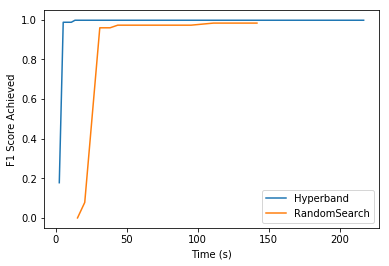

In [41]:
import matplotlib.pyplot as plt

def plot_score_vs_time(rs_data, hb_data, logscale=False):
    plt.cla()
    
    if logscale:
        plt.xscale("log")
    
    xs_hyperband = [x["time_elapsed"] for x in hb_data]
    ys_hyperband = [x["best_score"] for x in hb_data]
    xs_rs = [x["time_elapsed"] for x in rs_data]
    ys_rs = [x["best_score"] for x in rs_data]
    
    plt.plot(xs_hyperband, ys_hyperband, label="Hyperband")
    plt.plot(xs_rs, ys_rs, label="RandomSearch")
    
    plt.xlabel("Time (s)")
    plt.ylabel("F1 Score Achieved")
        
    plt.legend(loc="best")
    
    
plot_score_vs_time(rs_best_score_stats, hb_best_score_stats)

Interesting! Our plot shows that Hyperband finds a good solution faster than random search. 

From the plot above, we see that Hyperband finds its best solution at around time 10s, whereas it takes random search around 40s to achieve a comparable score. 

The data above is very encouraging, however our previous setup may have been too simplistic. Let's make our search problem harder by expanding the search space and search time and comparing the performances of our tuners.

First let's define a harder search space.

In [37]:
harder_search_space = {
    'n_epochs': [1, 5, 10, 20, 40],
    'batchnorm' : [True, False],
    'dropout': [0, .1, .2, .3, .4, .5],
    'lr': {'range': [1e-7, 100], 'scale': 'log'},
    'layer_out_dims' : [
        [1000, 2],
        [1000, 1, 2],
        [1000, 10, 2], 
        [1000, 20, 2], 
        [1000, 30, 2], 
        [1000, 40, 2], 
        [1000, 50, 2], 
        [1000, 70, 2], 
        [1000, 100, 2],         
        [1000, 500, 2], 
        [1000, 700, 2]
    ],
    'print_every': 5,
    'data_loader_config': [{"batch_size": 256, "num_workers": 1}],
}

Next, let's create our tuners.

In [39]:
rs_tuner_harder = RandomSearchTuner(EndModel, seed=123, validation_metric="f1")
hb_tuner_harder = HyperbandTuner(EndModel, hyperband_epochs_budget=800, seed=123, validation_metric="f1")

|           Hyperband Schedule          |
Table consists of tuples of (num configs, num_resources_per_config)which specify how many configs to run andfor how many epochs. 
Each bracket starts with a list of random configurations which is successively halved according the schedule.
See the Hyperband paper (https://arxiv.org/pdf/1603.06560.pdf) for more details.
-----------------------------------------
Bracket 0: (27, 1) (9, 5) (3, 17) (1, 52)
Bracket 1: (9, 5) (3, 17) (1, 52)
Bracket 2: (6, 17) (2, 52)
Bracket 3: (4, 53)
-----------------------------------------


Then run the search process (this may take a few minutes!)

In [40]:
best_rs_model_harder = rs_tuner_harder.search(search_space, (X_dev, Y_dev), train_args=train_args, max_search=50, verbose=True)
best_hb_model_harder =  hb_tuner_harder.search(search_space, (X_dev, Y_dev), train_args=train_args, verbose=True)


Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[0] Testing {'n_epochs': 10, 'batchnorm': False, 'dropout': 0, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.3700237151852522}


Saving model at iteration 0 with best score 0.008
[E:0]	Train Loss: 0.843	Dev f1: 0.008


[E:5]	Train Loss: 0.577	Dev f1: 0.000


[E:9]	Train Loss: 0.577	Dev f1: 0.000
Restoring best model from iteration 0 with score 0.008
Finished Training
F1: 0.008
        y=1    y=2   
 l=1     1      0    
 l=2    245    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[1] Testing {'n_epochs': 5, 'batchnorm': False, 'dropout': 0.1, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.005214066731316457}


Saving model at iteration 0 with best score 0.984
[E:0]	Train Loss: 0.488	Dev f1: 0.984


[E:4]	Train Loss: 0.390	Dev f1: 0.819
Restoring best model from iteration 0 with score 0.984
Finished Training
F1: 0.984
        y=1    y=2   
 l=1    239     1    
 l=2     7     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[2] Testing {'n_epochs': 10, 'batchnorm': False, 'dropout': 0.4, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 1.585194679715539e-05}


Saving model at iteration 0 with best score 0.166
[E:0]	Train Loss: 0.679	Dev f1: 0.166


[E:5]	Train Loss: 0.623	Dev f1: 0.000


[E:9]	Train Loss: 0.583	Dev f1: 0.000
Restoring best model from iteration 0 with score 0.166
Finished Training
F1: 0.166
        y=1    y=2   
 l=1    24     20    
 l=2    222    734   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[3] Testing {'n_epochs': 5, 'batchnorm': True, 'dropout': 0.2, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.02036892667462041}


Saving model at iteration 0 with best score 0.986
[E:0]	Train Loss: 0.504	Dev f1: 0.986


[E:4]	Train Loss: 0.415	Dev f1: 0.948
Restoring best model from iteration 0 with score 0.986
Finished Training
F1: 0.986
        y=1    y=2   
 l=1    241     2    
 l=2     5     752   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[4] Testing {'n_epochs': 1, 'batchnorm': False, 'dropout': 0.2, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.4279302229694992}


Saving model at iteration 0 with best score 0.000
[E:0]	Train Loss: 4.569	Dev f1: 0.000
Restoring best model from iteration 0 with score 0.000
Finished Training
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[5] Testing {'n_epochs': 5, 'batchnorm': False, 'dropout': 0.4, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.09803180891807771}


Saving model at iteration 0 with best score 0.000
[E:0]	Train Loss: 0.826	Dev f1: 0.000


[E:4]	Train Loss: 0.575	Dev f1: 0.000
Restoring best model from iteration 0 with score 0.000
Finished Training
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[6] Testing {'n_epochs': 5, 'batchnorm': False, 'dropout': 0.2, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.02588490961967816}


Saving model at iteration 0 with best score 0.992
[E:0]	Train Loss: 0.508	Dev f1: 0.992


[E:4]	Train Loss: 0.448	Dev f1: 0.924
Restoring best model from iteration 0 with score 0.992
Finished Training
F1: 0.992
        y=1    y=2   
 l=1    244     2    
 l=2     2     752   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[7] Testing {'n_epochs': 1, 'batchnorm': False, 'dropout': 0.5, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 3.548852858974136e-05}


Saving model at iteration 0 with best score 0.024
[E:0]	Train Loss: 0.674	Dev f1: 0.024
Restoring best model from iteration 0 with score 0.024
Finished Training
F1: 0.024
        y=1    y=2   
 l=1     3      3    
 l=2    243    751   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[8] Testing {'n_epochs': 10, 'batchnorm': False, 'dropout': 0.1, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.4257481935428955}


Saving model at iteration 0 with best score 0.000
[E:0]	Train Loss: 4.799	Dev f1: 0.000


[E:5]	Train Loss: 0.580	Dev f1: 0.000


Saving model at iteration 9 with best score 0.008
[E:9]	Train Loss: 0.620	Dev f1: 0.008
Restoring best model from iteration 9 with score 0.008
Finished Training
F1: 0.008
        y=1    y=2   
 l=1     1      0    
 l=2    245    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[9] Testing {'n_epochs': 1, 'batchnorm': True, 'dropout': 0.3, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 2.7680136822513456e-05}


Saving model at iteration 0 with best score 0.100
[E:0]	Train Loss: 0.681	Dev f1: 0.100
Restoring best model from iteration 0 with score 0.100
Finished Training
F1: 0.100
        y=1    y=2   
 l=1    14     19    
 l=2    232    735   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[10] Testing {'n_epochs': 10, 'batchnorm': False, 'dropout': 0.3, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.029525943855712736}


Saving model at iteration 0 with best score 0.000
[E:0]	Train Loss: 0.540	Dev f1: 0.000


Saving model at iteration 1 with best score 0.971


[E:5]	Train Loss: 0.409	Dev f1: 0.915


[E:9]	Train Loss: 0.373	Dev f1: 0.887
Restoring best model from iteration 1 with score 0.971
Finished Training
F1: 0.971
        y=1    y=2   
 l=1    235     3    
 l=2    11     751   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[11] Testing {'n_epochs': 10, 'batchnorm': True, 'dropout': 0.3, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.05421565613438889}


Saving model at iteration 0 with best score 0.000
[E:0]	Train Loss: 0.687	Dev f1: 0.000


[E:5]	Train Loss: 0.575	Dev f1: 0.000


[E:9]	Train Loss: 0.575	Dev f1: 0.000
Restoring best model from iteration 0 with score 0.000
Finished Training
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[12] Testing {'n_epochs': 1, 'batchnorm': False, 'dropout': 0.1, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0010026911469111994}


Saving model at iteration 0 with best score 0.000
[E:0]	Train Loss: 0.544	Dev f1: 0.000
Restoring best model from iteration 0 with score 0.000
Finished Training
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[13] Testing {'n_epochs': 5, 'batchnorm': False, 'dropout': 0, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.7609305600840752}


Saving model at iteration 0 with best score 0.008
[E:0]	Train Loss: 9.848	Dev f1: 0.008


[E:4]	Train Loss: 0.664	Dev f1: 0.000
Restoring best model from iteration 0 with score 0.008
Finished Training
F1: 0.008
        y=1    y=2   
 l=1     1      0    
 l=2    245    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[14] Testing {'n_epochs': 1, 'batchnorm': False, 'dropout': 0.5, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.007161593465415848}


Saving model at iteration 0 with best score 0.960
[E:0]	Train Loss: 0.519	Dev f1: 0.960
Restoring best model from iteration 0 with score 0.960
Finished Training
F1: 0.960
        y=1    y=2   
 l=1    227     0    
 l=2    19     754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[15] Testing {'n_epochs': 10, 'batchnorm': False, 'dropout': 0.3, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.00012806126547915147}


Saving model at iteration 0 with best score 0.403
[E:0]	Train Loss: 0.738	Dev f1: 0.403


Saving model at iteration 1 with best score 0.443


[E:5]	Train Loss: 0.551	Dev f1: 0.108


Saving model at iteration 7 with best score 0.553


Saving model at iteration 8 with best score 0.691


Saving model at iteration 9 with best score 0.767
[E:9]	Train Loss: 0.486	Dev f1: 0.767
Restoring best model from iteration 9 with score 0.767
Finished Training
F1: 0.767
        y=1    y=2   
 l=1    153     0    
 l=2    93     754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[16] Testing {'n_epochs': 1, 'batchnorm': False, 'dropout': 0, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.03524235401554628}


Saving model at iteration 0 with best score 0.958
[E:0]	Train Loss: 0.496	Dev f1: 0.958
Restoring best model from iteration 0 with score 0.958
Finished Training
F1: 0.958
        y=1    y=2   
 l=1    227     1    
 l=2    19     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[17] Testing {'n_epochs': 10, 'batchnorm': False, 'dropout': 0, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 1.7350178602123415e-05}


Saving model at iteration 0 with best score 0.400
[E:0]	Train Loss: 0.717	Dev f1: 0.400


Saving model at iteration 1 with best score 0.432


Saving model at iteration 2 with best score 0.451


[E:5]	Train Loss: 0.640	Dev f1: 0.040


[E:9]	Train Loss: 0.586	Dev f1: 0.000
Restoring best model from iteration 2 with score 0.451
Finished Training
F1: 0.451
        y=1    y=2   
 l=1    107    122   
 l=2    139    632   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[18] Testing {'n_epochs': 5, 'batchnorm': True, 'dropout': 0.3, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.017045505152187078}


Saving model at iteration 0 with best score 0.969
[E:0]	Train Loss: 0.494	Dev f1: 0.969


[E:4]	Train Loss: 0.413	Dev f1: 0.926
Restoring best model from iteration 0 with score 0.969
Finished Training
F1: 0.969
        y=1    y=2   
 l=1    233     2    
 l=2    13     752   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[19] Testing {'n_epochs': 10, 'batchnorm': True, 'dropout': 0.4, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.005541944589749214}


Saving model at iteration 0 with best score 0.977
[E:0]	Train Loss: 0.502	Dev f1: 0.977


[E:5]	Train Loss: 0.427	Dev f1: 0.934


[E:9]	Train Loss: 0.407	Dev f1: 0.815
Restoring best model from iteration 0 with score 0.977
Finished Training
F1: 0.977
        y=1    y=2   
 l=1    235     0    
 l=2    11     754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[20] Testing {'n_epochs': 5, 'batchnorm': True, 'dropout': 0, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.004239574125046399}


Saving model at iteration 0 with best score 0.996
[E:0]	Train Loss: 0.490	Dev f1: 0.996


[E:4]	Train Loss: 0.392	Dev f1: 0.834
Restoring best model from iteration 0 with score 0.996
Finished Training
F1: 0.996
        y=1    y=2   
 l=1    245     1    
 l=2     1     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[21] Testing {'n_epochs': 5, 'batchnorm': False, 'dropout': 0.3, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0024715555153620662}


Saving model at iteration 0 with best score 0.992
[E:0]	Train Loss: 0.494	Dev f1: 0.992


[E:4]	Train Loss: 0.411	Dev f1: 0.885
Restoring best model from iteration 0 with score 0.992
Finished Training
F1: 0.992
        y=1    y=2   
 l=1    243     1    
 l=2     3     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[22] Testing {'n_epochs': 1, 'batchnorm': False, 'dropout': 0.3, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0009289431566714656}


Saving model at iteration 0 with best score 0.962
[E:0]	Train Loss: 0.530	Dev f1: 0.962
Restoring best model from iteration 0 with score 0.962
Finished Training
F1: 0.962
        y=1    y=2   
 l=1    228     0    
 l=2    18     754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[23] Testing {'n_epochs': 5, 'batchnorm': False, 'dropout': 0.2, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 1.8277169097502837e-05}


Saving model at iteration 0 with best score 0.166
[E:0]	Train Loss: 0.682	Dev f1: 0.166


[E:4]	Train Loss: 0.621	Dev f1: 0.000
Restoring best model from iteration 0 with score 0.166
Finished Training
F1: 0.165
        y=1    y=2   
 l=1    27     54    
 l=2    219    700   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[24] Testing {'n_epochs': 10, 'batchnorm': True, 'dropout': 0.2, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0033432163381272935}


Saving model at iteration 0 with best score 0.979
[E:0]	Train Loss: 0.486	Dev f1: 0.979


[E:5]	Train Loss: 0.367	Dev f1: 0.853


[E:9]	Train Loss: 0.320	Dev f1: 0.808
Restoring best model from iteration 0 with score 0.979
Finished Training
F1: 0.979
        y=1    y=2   
 l=1    237     1    
 l=2     9     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[25] Testing {'n_epochs': 5, 'batchnorm': True, 'dropout': 0.4, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 2.546285044205842e-05}


Saving model at iteration 0 with best score 0.278
[E:0]	Train Loss: 0.688	Dev f1: 0.278


[E:4]	Train Loss: 0.654	Dev f1: 0.024
Restoring best model from iteration 0 with score 0.278
Finished Training
F1: 0.278
        y=1    y=2   
 l=1    71     193   
 l=2    175    561   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[26] Testing {'n_epochs': 10, 'batchnorm': False, 'dropout': 0.4, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.00014560631588300617}


Saving model at iteration 0 with best score 0.409
[E:0]	Train Loss: 0.739	Dev f1: 0.409


Saving model at iteration 1 with best score 0.465


[E:5]	Train Loss: 0.573	Dev f1: 0.032


Saving model at iteration 8 with best score 0.598


Saving model at iteration 9 with best score 0.776
[E:9]	Train Loss: 0.502	Dev f1: 0.776
Restoring best model from iteration 9 with score 0.776
Finished Training
F1: 0.776
        y=1    y=2   
 l=1    156     0    
 l=2    90     754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[27] Testing {'n_epochs': 5, 'batchnorm': False, 'dropout': 0.5, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.23819791212085886}


Saving model at iteration 0 with best score 0.000
[E:0]	Train Loss: 1.768	Dev f1: 0.000


[E:4]	Train Loss: 0.576	Dev f1: 0.000
Restoring best model from iteration 0 with score 0.000
Finished Training
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[28] Testing {'n_epochs': 5, 'batchnorm': False, 'dropout': 0.5, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0008946559916154823}


Saving model at iteration 0 with best score 0.024
[E:0]	Train Loss: 0.582	Dev f1: 0.024


Saving model at iteration 1 with best score 0.814


Saving model at iteration 2 with best score 0.960


Saving model at iteration 3 with best score 0.975


Saving model at iteration 4 with best score 0.977
[E:4]	Train Loss: 0.450	Dev f1: 0.977
Restoring best model from iteration 4 with score 0.977
Finished Training
F1: 0.977
        y=1    y=2   
 l=1    236     1    
 l=2    10     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[29] Testing {'n_epochs': 5, 'batchnorm': False, 'dropout': 0, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.013675741331489702}


Saving model at iteration 0 with best score 0.000
[E:0]	Train Loss: 0.499	Dev f1: 0.000


Saving model at iteration 1 with best score 0.962


[E:4]	Train Loss: 0.447	Dev f1: 0.955
Restoring best model from iteration 1 with score 0.962
Finished Training
F1: 0.962
        y=1    y=2   
 l=1    230     2    
 l=2    16     752   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[30] Testing {'n_epochs': 5, 'batchnorm': True, 'dropout': 0.1, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.06592410262316929}


Saving model at iteration 0 with best score 0.986
[E:0]	Train Loss: 0.533	Dev f1: 0.986


[E:4]	Train Loss: 0.442	Dev f1: 0.948
Restoring best model from iteration 0 with score 0.986
Finished Training
F1: 0.986
        y=1    y=2   
 l=1    240     1    
 l=2     6     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[31] Testing {'n_epochs': 5, 'batchnorm': True, 'dropout': 0.4, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0001724754314363562}


Saving model at iteration 0 with best score 0.000
[E:0]	Train Loss: 0.641	Dev f1: 0.000


Saving model at iteration 1 with best score 0.008


Saving model at iteration 2 with best score 0.332


Saving model at iteration 3 with best score 0.842


Saving model at iteration 4 with best score 0.940
[E:4]	Train Loss: 0.460	Dev f1: 0.940
Restoring best model from iteration 4 with score 0.940
Finished Training
F1: 0.940
        y=1    y=2   
 l=1    218     0    
 l=2    28     754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[32] Testing {'n_epochs': 1, 'batchnorm': False, 'dropout': 0.2, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0022201091280121855}


Saving model at iteration 0 with best score 0.803
[E:0]	Train Loss: 0.543	Dev f1: 0.803
Restoring best model from iteration 0 with score 0.803
Finished Training
F1: 0.803
        y=1    y=2   
 l=1    165     0    
 l=2    81     754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[33] Testing {'n_epochs': 5, 'batchnorm': True, 'dropout': 0.3, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 3.260644225940145e-05}


Saving model at iteration 0 with best score 0.000
[E:0]	Train Loss: 0.624	Dev f1: 0.000


[E:4]	Train Loss: 0.590	Dev f1: 0.000
Restoring best model from iteration 0 with score 0.000
Finished Training
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[34] Testing {'n_epochs': 10, 'batchnorm': True, 'dropout': 0.1, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 6.117103289623889e-05}


Saving model at iteration 0 with best score 0.395
[E:0]	Train Loss: 0.759	Dev f1: 0.395


Saving model at iteration 3 with best score 0.397


Saving model at iteration 4 with best score 0.440


Saving model at iteration 5 with best score 0.510
[E:5]	Train Loss: 0.695	Dev f1: 0.510


Saving model at iteration 6 with best score 0.568


[E:9]	Train Loss: 0.654	Dev f1: 0.255
Restoring best model from iteration 6 with score 0.568
Finished Training
F1: 0.568
        y=1    y=2   
 l=1    151    135   
 l=2    95     619   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[35] Testing {'n_epochs': 1, 'batchnorm': False, 'dropout': 0.3, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.034371596790805016}


Saving model at iteration 0 with best score 0.981
[E:0]	Train Loss: 0.489	Dev f1: 0.981
Restoring best model from iteration 0 with score 0.981
Finished Training
F1: 0.981
        y=1    y=2   
 l=1    238     1    
 l=2     8     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[36] Testing {'n_epochs': 1, 'batchnorm': True, 'dropout': 0, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 1.4304509609501139e-05}


Saving model at iteration 0 with best score 0.023
[E:0]	Train Loss: 0.671	Dev f1: 0.023
Restoring best model from iteration 0 with score 0.023
Finished Training
F1: 0.023
        y=1    y=2   
 l=1     3     12    
 l=2    243    742   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[37] Testing {'n_epochs': 10, 'batchnorm': True, 'dropout': 0.5, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 1.83277317650445e-05}


Saving model at iteration 0 with best score 0.395
[E:0]	Train Loss: 0.809	Dev f1: 0.395


[E:5]	Train Loss: 0.786	Dev f1: 0.395


[E:9]	Train Loss: 0.767	Dev f1: 0.395
Restoring best model from iteration 0 with score 0.395
Finished Training
F1: 0.395
        y=1    y=2   
 l=1    246    754   
 l=2     0      0    

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[38] Testing {'n_epochs': 1, 'batchnorm': True, 'dropout': 0.4, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.363949058720442}


Saving model at iteration 0 with best score 0.000
[E:0]	Train Loss: 3.408	Dev f1: 0.000
Restoring best model from iteration 0 with score 0.000
Finished Training
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[39] Testing {'n_epochs': 10, 'batchnorm': False, 'dropout': 0.2, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.00040358865507417825}


Saving model at iteration 0 with best score 0.406
[E:0]	Train Loss: 0.782	Dev f1: 0.406


Saving model at iteration 4 with best score 0.667


Saving model at iteration 5 with best score 0.877
[E:5]	Train Loss: 0.479	Dev f1: 0.877


Saving model at iteration 6 with best score 0.933


Saving model at iteration 7 with best score 0.940


Saving model at iteration 8 with best score 0.942


Saving model at iteration 9 with best score 0.944
[E:9]	Train Loss: 0.453	Dev f1: 0.944
Restoring best model from iteration 9 with score 0.944
Finished Training
F1: 0.944
        y=1    y=2   
 l=1    221     1    
 l=2    25     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[40] Testing {'n_epochs': 1, 'batchnorm': True, 'dropout': 0.1, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 5.358395288838164e-05}


Saving model at iteration 0 with best score 0.000
[E:0]	Train Loss: 0.647	Dev f1: 0.000
Restoring best model from iteration 0 with score 0.000
Finished Training
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[41] Testing {'n_epochs': 10, 'batchnorm': False, 'dropout': 0.5, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.00582471682234333}


Saving model at iteration 0 with best score 0.992
[E:0]	Train Loss: 0.490	Dev f1: 0.992


[E:5]	Train Loss: 0.383	Dev f1: 0.863


[E:9]	Train Loss: 0.322	Dev f1: 0.792
Restoring best model from iteration 0 with score 0.992
Finished Training
F1: 0.992
        y=1    y=2   
 l=1    243     1    
 l=2     3     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[42] Testing {'n_epochs': 5, 'batchnorm': True, 'dropout': 0.2, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.007305933102137491}


Saving model at iteration 0 with best score 0.988
[E:0]	Train Loss: 0.507	Dev f1: 0.988


[E:4]	Train Loss: 0.432	Dev f1: 0.947
Restoring best model from iteration 0 with score 0.988
Finished Training
F1: 0.988
        y=1    y=2   
 l=1    241     1    
 l=2     5     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[43] Testing {'n_epochs': 1, 'batchnorm': False, 'dropout': 0.4, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0003417929176227784}


Saving model at iteration 0 with best score 0.450
[E:0]	Train Loss: 0.744	Dev f1: 0.450
Restoring best model from iteration 0 with score 0.450
Finished Training
F1: 0.450
        y=1    y=2   
 l=1    192    415   
 l=2    54     339   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[44] Testing {'n_epochs': 10, 'batchnorm': True, 'dropout': 0.1, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.9399327721514503}


Saving model at iteration 0 with best score 0.008
[E:0]	Train Loss: 19.142	Dev f1: 0.008


[E:5]	Train Loss: 0.626	Dev f1: 0.000


[E:9]	Train Loss: 0.593	Dev f1: 0.000
Restoring best model from iteration 0 with score 0.008
Finished Training
F1: 0.008
        y=1    y=2   
 l=1     1      0    
 l=2    245    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[45] Testing {'n_epochs': 10, 'batchnorm': False, 'dropout': 0.2, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.20229775745735415}


Saving model at iteration 0 with best score 0.000
[E:0]	Train Loss: 1.764	Dev f1: 0.000


[E:5]	Train Loss: 0.575	Dev f1: 0.000


[E:9]	Train Loss: 0.577	Dev f1: 0.000
Restoring best model from iteration 0 with score 0.000
Finished Training
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[46] Testing {'n_epochs': 5, 'batchnorm': True, 'dropout': 0, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.03065645141692306}


Saving model at iteration 0 with best score 0.958
[E:0]	Train Loss: 0.488	Dev f1: 0.958


Saving model at iteration 1 with best score 0.970


[E:4]	Train Loss: 0.436	Dev f1: 0.938
Restoring best model from iteration 1 with score 0.970
Finished Training
F1: 0.970
        y=1    y=2   
 l=1    243    12    
 l=2     3     742   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[47] Testing {'n_epochs': 5, 'batchnorm': False, 'dropout': 0.1, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 1.5494379731807828e-05}


Saving model at iteration 0 with best score 0.395
[E:0]	Train Loss: 0.768	Dev f1: 0.395


Saving model at iteration 4 with best score 0.396
[E:4]	Train Loss: 0.741	Dev f1: 0.396
Restoring best model from iteration 4 with score 0.396
Finished Training
F1: 0.396
        y=1    y=2   
 l=1    244    743   
 l=2     2     11    

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[48] Testing {'n_epochs': 1, 'batchnorm': True, 'dropout': 0.2, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0010513426180559643}


Saving model at iteration 0 with best score 0.869
[E:0]	Train Loss: 0.532	Dev f1: 0.869
Restoring best model from iteration 0 with score 0.869
Finished Training
F1: 0.869
        y=1    y=2   
 l=1    189     0    
 l=2    57     754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[49] Testing {'n_epochs': 10, 'batchnorm': True, 'dropout': 0, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0011169123855936244}


Saving model at iteration 0 with best score 0.949
[E:0]	Train Loss: 0.530	Dev f1: 0.949


Saving model at iteration 1 with best score 0.981


[E:5]	Train Loss: 0.421	Dev f1: 0.906


[E:9]	Train Loss: 0.371	Dev f1: 0.849
Restoring best model from iteration 1 with score 0.981
Finished Training
F1: 0.981
        y=1    y=2   
 l=1    238     1    
 l=2     8     753   
[SUMMARY]
Best model: [20]
Best config: {'n_epochs': 5, 'batchnorm': True, 'dropout': 0, 'layer_out_dims': [1000, 100, 2], 'print_every': 5, 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.004239574125046399}
Best score: 0.9959349593495935

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_0] Testing {'n_epochs': 1, 'batchnorm': True, 'dropout': 0.5, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.00042993833312388464}


Saving model at iteration 0 with best score 0.000
[E:0]	Train Loss: 0.592	Dev f1: 0.000
Restoring best model from iteration 0 with score 0.000
Finished Training
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_1] Testing {'n_epochs': 1, 'batchnorm': False, 'dropout': 0.4, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0016076627658489688}


Saving model at iteration 0 with best score 0.998
[E:0]	Train Loss: 0.502	Dev f1: 0.998
Restoring best model from iteration 0 with score 0.998
Finished Training
F1: 0.998
        y=1    y=2   
 l=1    246     1    
 l=2     0     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[0_2] Testing {'n_epochs': 1, 'batchnorm': False, 'dropout': 0.2, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.028198695336649943}


Saving model at iteration 0 with best score 0.977
[E:0]	Train Loss: 0.487	Dev f1: 0.977
Restoring best model from iteration 0 with score 0.977
Finished Training
F1: 0.977
        y=1    y=2   
 l=1    236     1    
 l=2    10     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[0_3] Testing {'n_epochs': 1, 'batchnorm': True, 'dropout': 0, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.00011305714909141539}


Saving model at iteration 0 with best score 0.000
[E:0]	Train Loss: 0.637	Dev f1: 0.000
Restoring best model from iteration 0 with score 0.000
Finished Training
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_4] Testing {'n_epochs': 1, 'batchnorm': True, 'dropout': 0.4, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.008592290740130197}


Saving model at iteration 0 with best score 0.971
[E:0]	Train Loss: 0.480	Dev f1: 0.971
Restoring best model from iteration 0 with score 0.971
Finished Training
F1: 0.971
        y=1    y=2   
 l=1    233     1    
 l=2    13     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_5] Testing {'n_epochs': 1, 'batchnorm': True, 'dropout': 0.4, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 3.8744386608676124e-05}


Saving model at iteration 0 with best score 0.024
[E:0]	Train Loss: 0.667	Dev f1: 0.024
Restoring best model from iteration 0 with score 0.024
Finished Training
F1: 0.024
        y=1    y=2   
 l=1     3      1    
 l=2    243    753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[0_6] Testing {'n_epochs': 1, 'batchnorm': True, 'dropout': 0.3, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 1.0621948388389852e-05}


Saving model at iteration 0 with best score 0.395
[E:0]	Train Loss: 0.754	Dev f1: 0.395
Restoring best model from iteration 0 with score 0.395
Finished Training
F1: 0.395
        y=1    y=2   
 l=1    246    754   
 l=2     0      0    

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[0_7] Testing {'n_epochs': 1, 'batchnorm': False, 'dropout': 0.3, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.8525815898433917}


Saving model at iteration 0 with best score 0.000
[E:0]	Train Loss: 2.935	Dev f1: 0.000
Restoring best model from iteration 0 with score 0.000
Finished Training
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_8] Testing {'n_epochs': 1, 'batchnorm': False, 'dropout': 0, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 3.38743136286116e-05}


Saving model at iteration 0 with best score 0.384
[E:0]	Train Loss: 0.695	Dev f1: 0.384
Restoring best model from iteration 0 with score 0.384
Finished Training
F1: 0.380
        y=1    y=2   
 l=1    88     129   
 l=2    158    625   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[0_9] Testing {'n_epochs': 1, 'batchnorm': True, 'dropout': 0.2, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.03344848810987344}


Saving model at iteration 0 with best score 0.990
[E:0]	Train Loss: 0.500	Dev f1: 0.990
Restoring best model from iteration 0 with score 0.990
Finished Training
F1: 0.990
        y=1    y=2   
 l=1    243     2    
 l=2     3     752   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[0_10] Testing {'n_epochs': 1, 'batchnorm': False, 'dropout': 0.5, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.05995807594941393}


Saving model at iteration 0 with best score 0.978
[E:0]	Train Loss: 0.493	Dev f1: 0.978
Restoring best model from iteration 0 with score 0.978
Finished Training
F1: 0.978
        y=1    y=2   
 l=1    241     6    
 l=2     5     748   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_11] Testing {'n_epochs': 1, 'batchnorm': True, 'dropout': 0.5, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 7.91010531176017e-05}


Saving model at iteration 0 with best score 0.100
[E:0]	Train Loss: 0.679	Dev f1: 0.100
Restoring best model from iteration 0 with score 0.100
Finished Training
F1: 0.100
        y=1    y=2   
 l=1    13      1    
 l=2    233    753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[0_12] Testing {'n_epochs': 1, 'batchnorm': True, 'dropout': 0.4, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 9.250923324118963e-05}


Saving model at iteration 0 with best score 0.395
[E:0]	Train Loss: 0.784	Dev f1: 0.395
Restoring best model from iteration 0 with score 0.395
Finished Training
F1: 0.395
        y=1    y=2   
 l=1    246    754   
 l=2     0      0    

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_13] Testing {'n_epochs': 1, 'batchnorm': True, 'dropout': 0.3, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.04801997781096232}


Saving model at iteration 0 with best score 0.000
[E:0]	Train Loss: 0.616	Dev f1: 0.000
Restoring best model from iteration 0 with score 0.000
Finished Training
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_14] Testing {'n_epochs': 1, 'batchnorm': False, 'dropout': 0.5, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.010293308474450997}


Saving model at iteration 0 with best score 0.992
[E:0]	Train Loss: 0.488	Dev f1: 0.992
Restoring best model from iteration 0 with score 0.992
Finished Training
F1: 0.992
        y=1    y=2   
 l=1    243     1    
 l=2     3     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_15] Testing {'n_epochs': 1, 'batchnorm': True, 'dropout': 0.1, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.00139235314523989}


Saving model at iteration 0 with best score 0.988
[E:0]	Train Loss: 0.505	Dev f1: 0.988
Restoring best model from iteration 0 with score 0.988
Finished Training
F1: 0.988
        y=1    y=2   
 l=1    241     1    
 l=2     5     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_16] Testing {'n_epochs': 1, 'batchnorm': True, 'dropout': 0.2, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.09478950348925456}


Saving model at iteration 0 with best score 0.000
[E:0]	Train Loss: 0.830	Dev f1: 0.000
Restoring best model from iteration 0 with score 0.000
Finished Training
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[0_17] Testing {'n_epochs': 1, 'batchnorm': True, 'dropout': 0.3, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0007325737096511143}


Saving model at iteration 0 with best score 0.000
[E:0]	Train Loss: 0.595	Dev f1: 0.000
Restoring best model from iteration 0 with score 0.000
Finished Training
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[0_18] Testing {'n_epochs': 1, 'batchnorm': True, 'dropout': 0.1, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.020191521289067548}


Saving model at iteration 0 with best score 0.979
[E:0]	Train Loss: 0.492	Dev f1: 0.979
Restoring best model from iteration 0 with score 0.979
Finished Training
F1: 0.979
        y=1    y=2   
 l=1    237     1    
 l=2     9     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_19] Testing {'n_epochs': 1, 'batchnorm': False, 'dropout': 0.2, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0003988997413713485}


Saving model at iteration 0 with best score 0.000
[E:0]	Train Loss: 0.592	Dev f1: 0.000
Restoring best model from iteration 0 with score 0.000
Finished Training
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[0_20] Testing {'n_epochs': 1, 'batchnorm': True, 'dropout': 0.4, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0986895261867101}


Saving model at iteration 0 with best score 0.979
[E:0]	Train Loss: 0.531	Dev f1: 0.979
Restoring best model from iteration 0 with score 0.979
Finished Training
F1: 0.979
        y=1    y=2   
 l=1    238     2    
 l=2     8     752   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_21] Testing {'n_epochs': 1, 'batchnorm': True, 'dropout': 0.3, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0020215477115438194}


Saving model at iteration 0 with best score 0.994
[E:0]	Train Loss: 0.511	Dev f1: 0.994
Restoring best model from iteration 0 with score 0.994
Finished Training
F1: 0.994
        y=1    y=2   
 l=1    244     1    
 l=2     2     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[0_22] Testing {'n_epochs': 1, 'batchnorm': False, 'dropout': 0.2, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0002664764399516124}


Saving model at iteration 0 with best score 0.000
[E:0]	Train Loss: 0.642	Dev f1: 0.000
Restoring best model from iteration 0 with score 0.000
Finished Training
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_23] Testing {'n_epochs': 1, 'batchnorm': True, 'dropout': 0.1, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.03498431484265373}


Saving model at iteration 0 with best score 0.000
[E:0]	Train Loss: 0.581	Dev f1: 0.000
Restoring best model from iteration 0 with score 0.000
Finished Training
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_24] Testing {'n_epochs': 1, 'batchnorm': True, 'dropout': 0.1, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.06109891153741962}


Saving model at iteration 0 with best score 0.000
[E:0]	Train Loss: 0.723	Dev f1: 0.000
Restoring best model from iteration 0 with score 0.000
Finished Training
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_25] Testing {'n_epochs': 1, 'batchnorm': False, 'dropout': 0.5, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 5.7473955465400216e-05}


Saving model at iteration 0 with best score 0.000
[E:0]	Train Loss: 0.657	Dev f1: 0.000
Restoring best model from iteration 0 with score 0.000
Finished Training
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_26] Testing {'n_epochs': 1, 'batchnorm': False, 'dropout': 0.1, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.11741748061948316}


Saving model at iteration 0 with best score 0.000
[E:0]	Train Loss: 0.892	Dev f1: 0.000
Restoring best model from iteration 0 with score 0.000
Finished Training
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[1_0] Testing {'n_epochs': 5, 'batchnorm': False, 'dropout': 0.4, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0016076627658489688}


Saving model at iteration 0 with best score 0.994
[E:0]	Train Loss: 0.509	Dev f1: 0.994


[E:4]	Train Loss: 0.421	Dev f1: 0.908
Restoring best model from iteration 0 with score 0.994
Finished Training
F1: 0.994
        y=1    y=2   
 l=1    244     1    
 l=2     2     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[1_1] Testing {'n_epochs': 5, 'batchnorm': True, 'dropout': 0.3, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0020215477115438194}


Saving model at iteration 0 with best score 0.994
[E:0]	Train Loss: 0.498	Dev f1: 0.994


[E:4]	Train Loss: 0.414	Dev f1: 0.864
Restoring best model from iteration 0 with score 0.994
Finished Training
F1: 0.994
        y=1    y=2   
 l=1    245     2    
 l=2     1     752   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[1_2] Testing {'n_epochs': 5, 'batchnorm': False, 'dropout': 0.5, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.010293308474450997}


Saving model at iteration 0 with best score 0.962
[E:0]	Train Loss: 0.489	Dev f1: 0.962


[E:4]	Train Loss: 0.373	Dev f1: 0.828
Restoring best model from iteration 0 with score 0.962
Finished Training
F1: 0.962
        y=1    y=2   
 l=1    228     0    
 l=2    18     754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[1_3] Testing {'n_epochs': 5, 'batchnorm': True, 'dropout': 0.2, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.03344848810987344}


Saving model at iteration 0 with best score 0.973
[E:0]	Train Loss: 0.483	Dev f1: 0.973


[E:4]	Train Loss: 0.408	Dev f1: 0.817
Restoring best model from iteration 0 with score 0.973
Finished Training
F1: 0.973
        y=1    y=2   
 l=1    234     1    
 l=2    12     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[1_4] Testing {'n_epochs': 5, 'batchnorm': True, 'dropout': 0.1, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.00139235314523989}


Saving model at iteration 0 with best score 0.992
[E:0]	Train Loss: 0.517	Dev f1: 0.992


[E:4]	Train Loss: 0.425	Dev f1: 0.918
Restoring best model from iteration 0 with score 0.992
Finished Training
F1: 0.992
        y=1    y=2   
 l=1    243     1    
 l=2     3     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[1_5] Testing {'n_epochs': 5, 'batchnorm': True, 'dropout': 0.4, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0986895261867101}


Saving model at iteration 0 with best score 0.994
[E:0]	Train Loss: 0.587	Dev f1: 0.994


[E:4]	Train Loss: 0.445	Dev f1: 0.954
Restoring best model from iteration 0 with score 0.994
Finished Training
F1: 0.994
        y=1    y=2   
 l=1    244     1    
 l=2     2     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[1_6] Testing {'n_epochs': 5, 'batchnorm': True, 'dropout': 0.1, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.020191521289067548}


Saving model at iteration 0 with best score 0.967
[E:0]	Train Loss: 0.498	Dev f1: 0.967


Saving model at iteration 3 with best score 0.967


[E:4]	Train Loss: 0.440	Dev f1: 0.946
Restoring best model from iteration 3 with score 0.967
Finished Training
F1: 0.967
        y=1    y=2   
 l=1    237     7    
 l=2     9     747   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[1_7] Testing {'n_epochs': 5, 'batchnorm': False, 'dropout': 0.5, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.05995807594941393}


Saving model at iteration 0 with best score 0.935
[E:0]	Train Loss: 0.497	Dev f1: 0.935


Saving model at iteration 1 with best score 0.954


Saving model at iteration 2 with best score 0.956


[E:4]	Train Loss: 0.440	Dev f1: 0.931
Restoring best model from iteration 2 with score 0.956
Finished Training
F1: 0.956
        y=1    y=2   
 l=1    230     5    
 l=2    16     749   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[1_8] Testing {'n_epochs': 5, 'batchnorm': False, 'dropout': 0.2, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.028198695336649943}


Saving model at iteration 0 with best score 0.990
[E:0]	Train Loss: 0.498	Dev f1: 0.990


[E:4]	Train Loss: 0.444	Dev f1: 0.959
Restoring best model from iteration 0 with score 0.990
Finished Training
F1: 0.990
        y=1    y=2   
 l=1    242     1    
 l=2     4     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[2_0] Testing {'n_epochs': 17, 'batchnorm': True, 'dropout': 0.3, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0020215477115438194}


Saving model at iteration 0 with best score 0.994
[E:0]	Train Loss: 0.507	Dev f1: 0.994


[E:5]	Train Loss: 0.397	Dev f1: 0.858


[E:10]	Train Loss: 0.325	Dev f1: 0.851


[E:15]	Train Loss: 0.309	Dev f1: 0.821


[E:16]	Train Loss: 0.308	Dev f1: 0.821
Restoring best model from iteration 0 with score 0.994
Finished Training
F1: 0.994
        y=1    y=2   
 l=1    244     1    
 l=2     2     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[2_1] Testing {'n_epochs': 17, 'batchnorm': False, 'dropout': 0.4, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0016076627658489688}


Saving model at iteration 0 with best score 0.994
[E:0]	Train Loss: 0.514	Dev f1: 0.994


[E:5]	Train Loss: 0.401	Dev f1: 0.894


[E:10]	Train Loss: 0.325	Dev f1: 0.856


[E:15]	Train Loss: 0.309	Dev f1: 0.799


[E:16]	Train Loss: 0.308	Dev f1: 0.836
Restoring best model from iteration 0 with score 0.994
Finished Training
F1: 0.994
        y=1    y=2   
 l=1    244     1    
 l=2     2     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[2_2] Testing {'n_epochs': 17, 'batchnorm': True, 'dropout': 0.4, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0986895261867101}


Saving model at iteration 0 with best score 0.272
[E:0]	Train Loss: 0.606	Dev f1: 0.272


Saving model at iteration 1 with best score 0.553


Saving model at iteration 2 with best score 0.878


Saving model at iteration 3 with best score 0.910


[E:5]	Train Loss: 0.439	Dev f1: 0.843


[E:10]	Train Loss: 0.437	Dev f1: 0.809


[E:15]	Train Loss: 0.429	Dev f1: 0.838


[E:16]	Train Loss: 0.430	Dev f1: 0.776
Restoring best model from iteration 3 with score 0.910
Finished Training
F1: 0.910
        y=1    y=2   
 l=1    208     3    
 l=2    38     751   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[3_0] Testing {'n_epochs': 52, 'batchnorm': True, 'dropout': 0.3, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0020215477115438194}


Saving model at iteration 0 with best score 0.998
[E:0]	Train Loss: 0.504	Dev f1: 0.998


[E:5]	Train Loss: 0.398	Dev f1: 0.865


[E:10]	Train Loss: 0.327	Dev f1: 0.809


[E:15]	Train Loss: 0.309	Dev f1: 0.816


[E:20]	Train Loss: 0.305	Dev f1: 0.794


[E:25]	Train Loss: 0.298	Dev f1: 0.810


[E:30]	Train Loss: 0.297	Dev f1: 0.806


[E:35]	Train Loss: 0.297	Dev f1: 0.799


[E:40]	Train Loss: 0.297	Dev f1: 0.794


[E:45]	Train Loss: 0.297	Dev f1: 0.791


[E:50]	Train Loss: 0.297	Dev f1: 0.791


[E:51]	Train Loss: 0.297	Dev f1: 0.791
Restoring best model from iteration 0 with score 0.998
Finished Training
F1: 0.998
        y=1    y=2   
 l=1    245     0    
 l=2     1     754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_0] Testing {'n_epochs': 5, 'batchnorm': True, 'dropout': 0.3, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0020090441841121454}


Saving model at iteration 0 with best score 0.994
[E:0]	Train Loss: 0.503	Dev f1: 0.994


[E:4]	Train Loss: 0.413	Dev f1: 0.932
Restoring best model from iteration 0 with score 0.994
Finished Training
F1: 0.994
        y=1    y=2   
 l=1    244     1    
 l=2     2     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_1] Testing {'n_epochs': 5, 'batchnorm': False, 'dropout': 0.2, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.00020067998217831992}


Saving model at iteration 0 with best score 0.000
[E:0]	Train Loss: 0.625	Dev f1: 0.000


Saving model at iteration 1 with best score 0.016


Saving model at iteration 2 with best score 0.767


Saving model at iteration 3 with best score 0.949


Saving model at iteration 4 with best score 0.951
[E:4]	Train Loss: 0.454	Dev f1: 0.951
Restoring best model from iteration 4 with score 0.951
Finished Training
F1: 0.951
        y=1    y=2   
 l=1    223     0    
 l=2    23     754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[0_2] Testing {'n_epochs': 5, 'batchnorm': False, 'dropout': 0.2, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.02024784233814557}


Saving model at iteration 0 with best score 0.971
[E:0]	Train Loss: 0.489	Dev f1: 0.971


[E:4]	Train Loss: 0.423	Dev f1: 0.915
Restoring best model from iteration 0 with score 0.971
Finished Training
F1: 0.971
        y=1    y=2   
 l=1    234     2    
 l=2    12     752   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_3] Testing {'n_epochs': 5, 'batchnorm': False, 'dropout': 0.4, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0373471340918514}


Saving model at iteration 0 with best score 0.000
[E:0]	Train Loss: 0.570	Dev f1: 0.000


Saving model at iteration 1 with best score 0.956


Saving model at iteration 2 with best score 0.965


[E:4]	Train Loss: 0.440	Dev f1: 0.946
Restoring best model from iteration 2 with score 0.965
Finished Training
F1: 0.965
        y=1    y=2   
 l=1    236     7    
 l=2    10     747   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_4] Testing {'n_epochs': 5, 'batchnorm': True, 'dropout': 0.3, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.00029872701671842606}


Saving model at iteration 0 with best score 0.000
[E:0]	Train Loss: 0.607	Dev f1: 0.000


Saving model at iteration 1 with best score 0.582


Saving model at iteration 2 with best score 0.962


[E:4]	Train Loss: 0.449	Dev f1: 0.953
Restoring best model from iteration 2 with score 0.962
Finished Training
F1: 0.962
        y=1    y=2   
 l=1    228     0    
 l=2    18     754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_5] Testing {'n_epochs': 5, 'batchnorm': True, 'dropout': 0.1, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 1.1063607762376659e-05}


Saving model at iteration 0 with best score 0.396
[E:0]	Train Loss: 0.725	Dev f1: 0.396


Saving model at iteration 1 with best score 0.405


Saving model at iteration 2 with best score 0.449


Saving model at iteration 3 with best score 0.496


[E:4]	Train Loss: 0.684	Dev f1: 0.490
Restoring best model from iteration 3 with score 0.496
Finished Training
F1: 0.496
        y=1    y=2   
 l=1    181    303   
 l=2    65     451   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[0_6] Testing {'n_epochs': 5, 'batchnorm': True, 'dropout': 0.3, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.18620576851485515}


Saving model at iteration 0 with best score 0.000
[E:0]	Train Loss: 0.706	Dev f1: 0.000


[E:4]	Train Loss: 0.580	Dev f1: 0.000
Restoring best model from iteration 0 with score 0.000
Finished Training
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_7] Testing {'n_epochs': 5, 'batchnorm': True, 'dropout': 0, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 8.565922479259012e-05}


Saving model at iteration 0 with best score 0.000
[E:0]	Train Loss: 0.631	Dev f1: 0.000


Saving model at iteration 4 with best score 0.243
[E:4]	Train Loss: 0.496	Dev f1: 0.243
Restoring best model from iteration 4 with score 0.243
Finished Training
F1: 0.243
        y=1    y=2   
 l=1    34      0    
 l=2    212    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_8] Testing {'n_epochs': 5, 'batchnorm': False, 'dropout': 0, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.11820437420203461}


Saving model at iteration 0 with best score 0.000
[E:0]	Train Loss: 0.939	Dev f1: 0.000


Saving model at iteration 2 with best score 0.136


Saving model at iteration 3 with best score 0.831


Saving model at iteration 4 with best score 0.945
[E:4]	Train Loss: 0.465	Dev f1: 0.945
Restoring best model from iteration 4 with score 0.945
Finished Training
F1: 0.945
        y=1    y=2   
 l=1    224     4    
 l=2    22     750   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[1_0] Testing {'n_epochs': 17, 'batchnorm': True, 'dropout': 0.3, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0020090441841121454}


Saving model at iteration 0 with best score 0.994
[E:0]	Train Loss: 0.508	Dev f1: 0.994


[E:5]	Train Loss: 0.398	Dev f1: 0.874


[E:10]	Train Loss: 0.329	Dev f1: 0.842


[E:15]	Train Loss: 0.311	Dev f1: 0.842


[E:16]	Train Loss: 0.310	Dev f1: 0.829
Restoring best model from iteration 0 with score 0.994
Finished Training
F1: 0.994
        y=1    y=2   
 l=1    245     2    
 l=2     1     752   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[1_1] Testing {'n_epochs': 17, 'batchnorm': False, 'dropout': 0.2, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.02024784233814557}


Saving model at iteration 0 with best score 0.937
[E:0]	Train Loss: 0.491	Dev f1: 0.937


Saving model at iteration 1 with best score 0.963


[E:5]	Train Loss: 0.417	Dev f1: 0.827


[E:10]	Train Loss: 0.385	Dev f1: 0.766


[E:15]	Train Loss: 0.363	Dev f1: 0.720


[E:16]	Train Loss: 0.358	Dev f1: 0.804
Restoring best model from iteration 1 with score 0.963
Finished Training
F1: 0.963
        y=1    y=2   
 l=1    233     5    
 l=2    13     749   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[1_2] Testing {'n_epochs': 17, 'batchnorm': False, 'dropout': 0.4, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0373471340918514}


Saving model at iteration 0 with best score 0.000
[E:0]	Train Loss: 0.559	Dev f1: 0.000


Saving model at iteration 1 with best score 0.965


[E:5]	Train Loss: 0.420	Dev f1: 0.923


[E:10]	Train Loss: 0.387	Dev f1: 0.889


[E:15]	Train Loss: 0.363	Dev f1: 0.858


[E:16]	Train Loss: 0.361	Dev f1: 0.838
Restoring best model from iteration 1 with score 0.965
Finished Training
F1: 0.965
        y=1    y=2   
 l=1    235     6    
 l=2    11     748   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[2_0] Testing {'n_epochs': 52, 'batchnorm': True, 'dropout': 0.3, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0020090441841121454}


Saving model at iteration 0 with best score 0.994
[E:0]	Train Loss: 0.510	Dev f1: 0.994


[E:5]	Train Loss: 0.406	Dev f1: 0.906


[E:10]	Train Loss: 0.328	Dev f1: 0.810


[E:15]	Train Loss: 0.309	Dev f1: 0.805


[E:20]	Train Loss: 0.304	Dev f1: 0.805


[E:25]	Train Loss: 0.302	Dev f1: 0.800


[E:30]	Train Loss: 0.301	Dev f1: 0.804


[E:35]	Train Loss: 0.300	Dev f1: 0.800


[E:40]	Train Loss: 0.300	Dev f1: 0.788


[E:45]	Train Loss: 0.300	Dev f1: 0.789


[E:50]	Train Loss: 0.297	Dev f1: 0.799


[E:51]	Train Loss: 0.296	Dev f1: 0.794
Restoring best model from iteration 0 with score 0.994
Finished Training
F1: 0.994
        y=1    y=2   
 l=1    244     1    
 l=2     2     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[0_0] Testing {'n_epochs': 17, 'batchnorm': True, 'dropout': 0, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.9734642468432616}


Saving model at iteration 0 with best score 0.000
[E:0]	Train Loss: 2.818	Dev f1: 0.000


[E:5]	Train Loss: 0.585	Dev f1: 0.000


[E:10]	Train Loss: 0.578	Dev f1: 0.000


[E:15]	Train Loss: 0.580	Dev f1: 0.000


[E:16]	Train Loss: 0.580	Dev f1: 0.000
Restoring best model from iteration 0 with score 0.000
Finished Training
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[0_1] Testing {'n_epochs': 17, 'batchnorm': False, 'dropout': 0.4, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0016158506614733794}


Saving model at iteration 0 with best score 0.000
[E:0]	Train Loss: 0.606	Dev f1: 0.000


Saving model at iteration 1 with best score 0.944


Saving model at iteration 2 with best score 0.966


[E:5]	Train Loss: 0.441	Dev f1: 0.949


[E:10]	Train Loss: 0.415	Dev f1: 0.872


[E:15]	Train Loss: 0.399	Dev f1: 0.845


[E:16]	Train Loss: 0.397	Dev f1: 0.846
Restoring best model from iteration 2 with score 0.966
Finished Training
F1: 0.966
        y=1    y=2   
 l=1    230     0    
 l=2    16     754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[0_2] Testing {'n_epochs': 17, 'batchnorm': True, 'dropout': 0.2, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0005275518309947114}


Saving model at iteration 0 with best score 0.000
[E:0]	Train Loss: 0.584	Dev f1: 0.000


Saving model at iteration 1 with best score 0.602


Saving model at iteration 2 with best score 0.899


Saving model at iteration 3 with best score 0.928


Saving model at iteration 4 with best score 0.935


Saving model at iteration 5 with best score 0.937
[E:5]	Train Loss: 0.447	Dev f1: 0.937


[E:10]	Train Loss: 0.437	Dev f1: 0.914


[E:15]	Train Loss: 0.431	Dev f1: 0.905


[E:16]	Train Loss: 0.431	Dev f1: 0.907
Restoring best model from iteration 5 with score 0.937
Finished Training
F1: 0.937
        y=1    y=2   
 l=1    217     0    
 l=2    29     754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_3] Testing {'n_epochs': 17, 'batchnorm': True, 'dropout': 0.1, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0020432379869200416}


Saving model at iteration 0 with best score 0.996
[E:0]	Train Loss: 0.510	Dev f1: 0.996


[E:5]	Train Loss: 0.402	Dev f1: 0.845


[E:10]	Train Loss: 0.329	Dev f1: 0.800


[E:15]	Train Loss: 0.311	Dev f1: 0.797


[E:16]	Train Loss: 0.310	Dev f1: 0.805
Restoring best model from iteration 0 with score 0.996
Finished Training
F1: 0.996
        y=1    y=2   
 l=1    244     0    
 l=2     2     754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_4] Testing {'n_epochs': 17, 'batchnorm': True, 'dropout': 0.1, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.00038390168731899905}


Saving model at iteration 0 with best score 0.000
[E:0]	Train Loss: 0.586	Dev f1: 0.000


Saving model at iteration 1 with best score 0.892


Saving model at iteration 2 with best score 0.947


Saving model at iteration 3 with best score 0.956


[E:5]	Train Loss: 0.441	Dev f1: 0.949


[E:10]	Train Loss: 0.420	Dev f1: 0.922


[E:15]	Train Loss: 0.403	Dev f1: 0.901


[E:16]	Train Loss: 0.401	Dev f1: 0.899
Restoring best model from iteration 3 with score 0.956
Finished Training
F1: 0.956
        y=1    y=2   
 l=1    226     1    
 l=2    20     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_5] Testing {'n_epochs': 17, 'batchnorm': False, 'dropout': 0.3, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.13877477142234135}


Saving model at iteration 0 with best score 0.000
[E:0]	Train Loss: 1.220	Dev f1: 0.000


[E:5]	Train Loss: 0.575	Dev f1: 0.000


[E:10]	Train Loss: 0.575	Dev f1: 0.000


[E:15]	Train Loss: 0.575	Dev f1: 0.000


[E:16]	Train Loss: 0.575	Dev f1: 0.000
Restoring best model from iteration 0 with score 0.000
Finished Training
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[1_0] Testing {'n_epochs': 52, 'batchnorm': True, 'dropout': 0.1, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0020432379869200416}


Saving model at iteration 0 with best score 0.994
[E:0]	Train Loss: 0.506	Dev f1: 0.994


[E:5]	Train Loss: 0.403	Dev f1: 0.879


[E:10]	Train Loss: 0.331	Dev f1: 0.782


[E:15]	Train Loss: 0.310	Dev f1: 0.756


[E:20]	Train Loss: 0.304	Dev f1: 0.764


[E:25]	Train Loss: 0.302	Dev f1: 0.778


[E:30]	Train Loss: 0.297	Dev f1: 0.788


[E:35]	Train Loss: 0.297	Dev f1: 0.792


[E:40]	Train Loss: 0.297	Dev f1: 0.786


[E:45]	Train Loss: 0.296	Dev f1: 0.786


[E:50]	Train Loss: 0.296	Dev f1: 0.786


[E:51]	Train Loss: 0.296	Dev f1: 0.783
Restoring best model from iteration 0 with score 0.994
Finished Training
F1: 0.994
        y=1    y=2   
 l=1    245     2    
 l=2     1     752   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[1_1] Testing {'n_epochs': 52, 'batchnorm': False, 'dropout': 0.4, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0016158506614733794}


Saving model at iteration 0 with best score 0.000
[E:0]	Train Loss: 0.519	Dev f1: 0.000


Saving model at iteration 1 with best score 0.988


[E:5]	Train Loss: 0.436	Dev f1: 0.949


[E:10]	Train Loss: 0.422	Dev f1: 0.930


[E:15]	Train Loss: 0.412	Dev f1: 0.880


[E:20]	Train Loss: 0.407	Dev f1: 0.865


[E:25]	Train Loss: 0.401	Dev f1: 0.855


[E:30]	Train Loss: 0.398	Dev f1: 0.845


[E:35]	Train Loss: 0.394	Dev f1: 0.845


[E:40]	Train Loss: 0.392	Dev f1: 0.846


[E:45]	Train Loss: 0.390	Dev f1: 0.846


[E:50]	Train Loss: 0.389	Dev f1: 0.843


[E:51]	Train Loss: 0.389	Dev f1: 0.841
Restoring best model from iteration 1 with score 0.988
Finished Training
F1: 0.988
        y=1    y=2   
 l=1    240     0    
 l=2     6     754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_0] Testing {'n_epochs': 53, 'batchnorm': False, 'dropout': 0.5, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.18683821351710966}


Saving model at iteration 0 with best score 0.000
[E:0]	Train Loss: 1.565	Dev f1: 0.000


Saving model at iteration 2 with best score 0.008


[E:5]	Train Loss: 0.574	Dev f1: 0.000


[E:10]	Train Loss: 0.576	Dev f1: 0.000


[E:15]	Train Loss: 0.575	Dev f1: 0.000


[E:20]	Train Loss: 0.575	Dev f1: 0.000


[E:25]	Train Loss: 0.575	Dev f1: 0.000


[E:30]	Train Loss: 0.575	Dev f1: 0.000


[E:35]	Train Loss: 0.574	Dev f1: 0.000


[E:40]	Train Loss: 0.575	Dev f1: 0.000


[E:45]	Train Loss: 0.574	Dev f1: 0.000


[E:50]	Train Loss: 0.575	Dev f1: 0.000


[E:52]	Train Loss: 0.574	Dev f1: 0.000
Restoring best model from iteration 2 with score 0.008
Finished Training
F1: 0.008
        y=1    y=2   
 l=1     1      0    
 l=2    245    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_1] Testing {'n_epochs': 53, 'batchnorm': True, 'dropout': 0, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.07391271892032933}


Saving model at iteration 0 with best score 0.000
[E:0]	Train Loss: 0.751	Dev f1: 0.000


[E:5]	Train Loss: 0.575	Dev f1: 0.000


[E:10]	Train Loss: 0.574	Dev f1: 0.000


[E:15]	Train Loss: 0.575	Dev f1: 0.000


[E:20]	Train Loss: 0.574	Dev f1: 0.000


[E:25]	Train Loss: 0.574	Dev f1: 0.000


[E:30]	Train Loss: 0.574	Dev f1: 0.000


[E:35]	Train Loss: 0.574	Dev f1: 0.000


[E:40]	Train Loss: 0.574	Dev f1: 0.000


[E:45]	Train Loss: 0.574	Dev f1: 0.000


[E:50]	Train Loss: 0.574	Dev f1: 0.000


[E:52]	Train Loss: 0.574	Dev f1: 0.000
Restoring best model from iteration 0 with score 0.000
Finished Training
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_2] Testing {'n_epochs': 53, 'batchnorm': False, 'dropout': 0.2, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.8890424177984542}


Saving model at iteration 0 with best score 0.000
[E:0]	Train Loss: 19.600	Dev f1: 0.000


[E:5]	Train Loss: 0.702	Dev f1: 0.000


[E:10]	Train Loss: 0.616	Dev f1: 0.000


[E:15]	Train Loss: 0.589	Dev f1: 0.000


[E:20]	Train Loss: 0.578	Dev f1: 0.000


[E:25]	Train Loss: 0.577	Dev f1: 0.000


[E:30]	Train Loss: 0.579	Dev f1: 0.000


[E:35]	Train Loss: 0.576	Dev f1: 0.000


[E:40]	Train Loss: 0.577	Dev f1: 0.000


[E:45]	Train Loss: 0.575	Dev f1: 0.000


[E:50]	Train Loss: 0.575	Dev f1: 0.000


[E:52]	Train Loss: 0.575	Dev f1: 0.000
Restoring best model from iteration 0 with score 0.000
Finished Training
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[0_3] Testing {'n_epochs': 53, 'batchnorm': False, 'dropout': 0.2, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.009942135259085879}


Saving model at iteration 0 with best score 0.986
[E:0]	Train Loss: 0.515	Dev f1: 0.986


[E:5]	Train Loss: 0.447	Dev f1: 0.925


[E:10]	Train Loss: 0.441	Dev f1: 0.922


[E:15]	Train Loss: 0.433	Dev f1: 0.918


[E:20]	Train Loss: 0.414	Dev f1: 0.881


[E:25]	Train Loss: 0.393	Dev f1: 0.867


[E:30]	Train Loss: 0.379	Dev f1: 0.850


[E:35]	Train Loss: 0.367	Dev f1: 0.797


[E:40]	Train Loss: 0.357	Dev f1: 0.797


[E:45]	Train Loss: 0.350	Dev f1: 0.770


[E:50]	Train Loss: 0.345	Dev f1: 0.731


[E:52]	Train Loss: 0.343	Dev f1: 0.742
Restoring best model from iteration 0 with score 0.986
Finished Training
F1: 0.986
        y=1    y=2   
 l=1    241     2    
 l=2     5     752   
[SUMMARY]
Best model: [0_1]
Best config: {'n_epochs': 17, 'batchnorm': False, 'dropout': 0.4, 'layer_out_dims': [1000, 100, 2], 'print_every': 5, 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0016076627658489688}
Best score: 0.9979716024340771


And extract and plot our data:

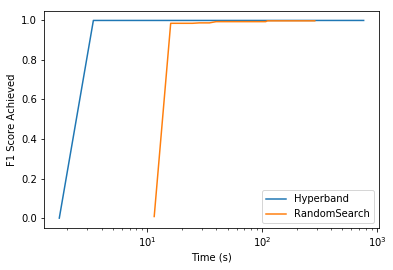

In [46]:
hb_stats_harder = hb_tuner_harder.run_stats
rs_stats_harder = rs_tuner_harder.run_stats
hb_best_score_stats_harder = gather_best_scores_from_stats(hb_stats_harder)
rs_best_score_stats_harder = gather_best_scores_from_stats(rs_stats_harder)
plot_score_vs_time(rs_best_score_stats_harder, hb_best_score_stats_harder, logscale=True)

Awesome! Generally it seems Hyperband is better in regimes with a large search space and a long search time (which is the typical scenario). 

This seems to make intuitive sense: 
- With a larger search space Hyperband's resource allocation becomes more useful in culling bad configurations.
- With a longer search time Hyperband is able to start with a larger pool of configurations, enabling a better balance of exploration / exploitation.

And that wraps up the hyperparameter tuning tutorial! We hope that MeTaL's hyperparameter tuners are useful for your applications and make hyperparameter tuning enjoyable. Happy tuning!